In this markdown we:
- Analyse annotations that are used to validate hair feature
- Determine and inspect hair feature function
- Validate hair feature function using violin graphs

### Annotations

1. Combining the two csv files with hair annotations from both M and P groups.


In [ ]:
import pandas as pd

dfm = pd.read_csv('group_m.csv')
dfp = pd.read_csv('group_p.csv')

combined_df = pd.concat([dfm, dfp], ignore_index=True)

combined_df.to_csv('hair_annotations.csv', index=False)

2. Analysing the agreement between annotators using Fleiss Kappa

In [1]:
from statsmodels.stats.inter_rater import fleiss_kappa
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

dfr = pd.read_csv('hair_annotations.csv')
ratings = dfr[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']]

#counting how many times each rating was given per image
def counting(row):
    counts = [0, 0, 0]  #for categories 0, 1, 2
    for v in row:
        counts[int(v)] += 1
    return counts

#creating a dataframe with rating frequencies
rating_counts = ratings.apply(counting, axis=1, result_type='expand')

#computing agreement using fleiss kappa function
data_matrix = rating_counts.values
kappa = fleiss_kappa(data_matrix, method='fleiss')
print(f"Fleiss' Kappa = {kappa:.3f}")




Fleiss' Kappa = 0.706


- Fleiss' Kappa = 1.0 → Perfect agreement

- Fleiss' Kappa = 0.0 → Agreement no better than chance

- Fleiss' Kappa < 0 → Worse than random (disagreement)

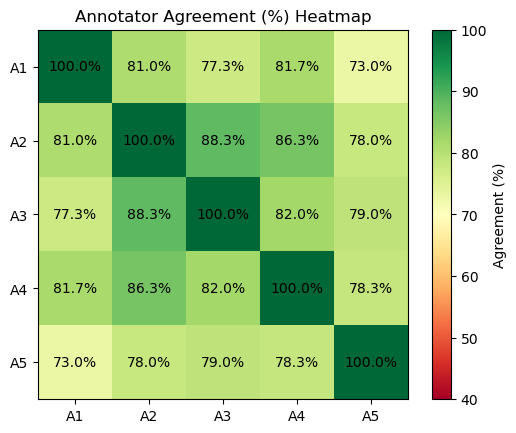

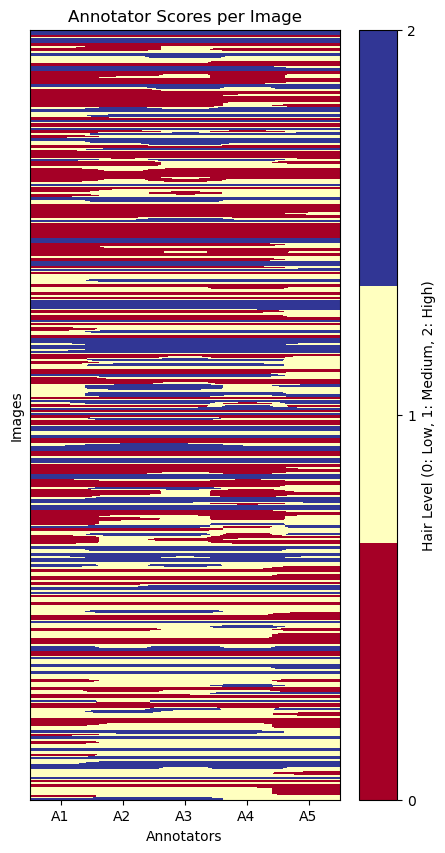

In [2]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt

#agreement percent (% accuracy)
df = pd.read_csv("hair_annotations.csv")
df = df.filter(like="Rating_").astype(int)

def get_agreement_percent(annotator_1, annotator_2, annotations):
    score_1 = f"Rating_{annotator_1}"
    score_2 = f"Rating_{annotator_2}"
    agreement_percent = (annotations[score_1] == annotations[score_2]).mean() * 100
    return agreement_percent.round(1)

def agreement_results(n, annotations):
    agreement_mtx = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

    for i in range(n):
        for j in range(n):
            if i == j:
                agreement_mtx.iloc[i, j] = 100.0
            else:
                agreement_mtx.iloc[i, j] = get_agreement_percent(i+1,j+1, annotations)

    return agreement_mtx

agreement_df = agreement_results(5, df)
agreement_matrix = agreement_df.values

plt.figure()

cmap = plt.get_cmap("RdYlGn")  
vmin, vmax = 40, 100 

heatmap = plt.imshow(agreement_matrix, cmap=cmap, vmin=vmin, vmax=vmax)  

for i in range(agreement_matrix.shape[0]):
    for j in range(agreement_matrix.shape[1]):
        plt.text(j, i, f"{agreement_matrix[i, j]}%", ha='center', va='center', color='black')

plt.title("Annotator Agreement (%) Heatmap")
plt.xticks(range(5), labels=[f"A{i+1}" for i in range(5)])
plt.yticks(range(5), labels=[f"A{i+1}" for i in range(5)])

cbar = plt.colorbar(heatmap)
cbar.set_label("Agreement (%)")

plt.savefig("annotator_agreement.png", dpi=300, bbox_inches='tight')
plt.show()


#scores heatmap
score_matrix = df.values
plt.figure(figsize=(5,10))

cmap = plt.get_cmap("RdYlBu", 3)

plt.imshow(score_matrix, cmap=cmap, aspect="auto")
cbar = plt.colorbar(ticks=[0, 1, 2])
cbar.set_label("Hair Level (0: Low, 1: Medium, 2: High)")

plt.xticks(range(5), labels=[f"A{i+1}" for i in range(5)])
plt.yticks([],[])

plt.title("Annotator Scores per Image")
plt.xlabel("Annotators")
plt.ylabel("Images")

plt.savefig("annotation_scores.png", dpi=300, bbox_inches='tight')
plt.show()

3. Even though kappa score is suggesting that annotations are reliable, we check images that have low agreement and count how many of them there are. We set threshold: less or equal to 4 counts of common rating score --> low agreement image

In [5]:
from collections import Counter

def common_rating_count(row):
    counts = Counter(row)
    most_common = counts.most_common(1)[0][1]  #count of most common label
    return most_common

ratings['agreement'] = ratings.apply(common_rating_count, axis=1)

#grouping the data based on level of agreement
high_agreement = ratings[ratings['agreement'] >= 4]    
medium_agreement = ratings[ratings['agreement'] == 3]  
low_agreement = ratings[ratings['agreement'] <= 2]      

# Create a summary table
d = {
    'Standard': [
        'High standard (4 or more annotators agree)',
        'Acceptable (exactly 3 agree)',
        'Not acceptable (2 or fewer agree)'
    ],
    'Number of images': [
        len(high_agreement),
        len(medium_agreement),
        len(low_agreement)
    ]
}

overview = pd.DataFrame(d)
overview

C:\Users\Andrius\AppData\Local\Temp\ipykernel_5512\4124500856.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings['agreement'] = ratings.apply(common_rating_count, axis=1)


,Standard,Number of images
0,High standard (4 or more annotators agree),247
1,Acceptable (exactly 3 agree),53
2,Not acceptable (2 or fewer agree),0


4. Looking at pictures with acceptable standard to figure out why the disagreement might happen

In [6]:
medium_agreement
dfr.loc[medium_agreement.index].tail()

,File_ID,Group_ID,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5
258,img_2023,16,1,1,1,2,2
264,img_2029,16,1,1,2,1,2
270,img_2035,16,0,1,1,1,0
287,img_2052,16,2,2,1,2,1
299,img_2064,16,2,2,2,1,1


### Hair coverege - feature extraction for model predicting the amount of hair (later used in hair removal to adjust kernel size)

Hair amount is predicted using enhanced edge detection combining Sobel and Laplacian operators, with coverage calculated as the ratio of hair pixels to total lesion area

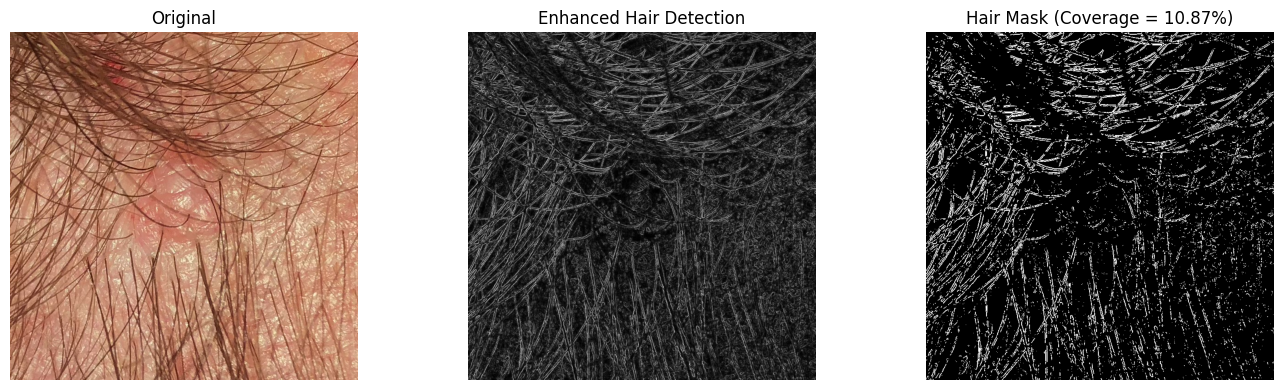

np.float64(0.1087)

In [4]:
import sys
import os

# Universal path
sys.path.append(os.path.abspath('..'))

import numpy as np
import cv2
import matplotlib.pyplot as plt
from util.inpaint_final import hair_coverage, enhance_hair_mask

def analyze_hair_coverage(image_path, visual=False):
    img_org = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
    mask = np.ones_like(img_gray)  # Full image mask for visualization

    #enhanced hair mask for visualization
    combined_edges = enhance_hair_mask(img_gray)
    threshold_value = int(0.3 * 255)
    hair_mask = (combined_edges > threshold_value).astype(np.uint8)

    #calculate coverage
    coverage = hair_coverage(img_gray, mask)

    if visual:
        plt.figure(figsize=(14, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(combined_edges, cmap='gray')
        plt.title('Enhanced Hair Detection')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(hair_mask * 255, cmap='gray')
        plt.title(f'Hair Mask (Coverage = {coverage:.2%})')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    return round(coverage, 4)

# image path
image_path = '../data/skin_images/PAT_21_31_965.png' #remeber to change the path wen we have data folder sorted out
analyze_hair_coverage(image_path, True)

Extracting feature for every picture

In [13]:
import cv2
import os
import pandas as pd
import numpy as np

# Update image directory path
image_dir = '../data/skin_images/'
data = pd.read_csv('hair_annotations.csv')
#create one label for an image (0,1,2), take the most frequent rating accross annotators
data['gt_label'] = data[['Rating_1', 'Rating_2', 'Rating_3', 'Rating_4', 'Rating_5']].mode(axis=1)[0]
#correction
data['File_ID'] = data['File_ID'].str.replace('.png', '', regex=False)

data['coverage'] = None

for idx, row in data.iterrows():
    img_id = row['File_ID']
    image_path = os.path.join(image_dir, img_id + '.png')

    if os.path.exists(image_path):
        # Load and process image
        img = cv2.imread(image_path)
        if img is not None:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            mask = np.ones_like(img_gray)  # Using full image mask
            coverage = hair_coverage(img_gray, mask)
            data.at[idx, 'coverage'] = coverage
        else:
            print(f"Failed to load image: {image_path}")
    else:
        print(f"Image not found: {image_path}")

data.head(15)

Image not found: ../data/skin_images/img_1572.png
Image not found: ../data/skin_images/img_1573.png
Image not found: ../data/skin_images/img_1574.png
Image not found: ../data/skin_images/img_1575.png
Image not found: ../data/skin_images/img_1576.png
Image not found: ../data/skin_images/img_1577.png
Image not found: ../data/skin_images/img_1578.png
Image not found: ../data/skin_images/img_1579.png
Image not found: ../data/skin_images/img_1580.png
Image not found: ../data/skin_images/img_1581.png
Image not found: ../data/skin_images/img_1582.png
Image not found: ../data/skin_images/img_1583.png
Image not found: ../data/skin_images/img_1584.png
Image not found: ../data/skin_images/img_1585.png
Image not found: ../data/skin_images/img_1586.png
Image not found: ../data/skin_images/img_1587.png
Image not found: ../data/skin_images/img_1588.png
Image not found: ../data/skin_images/img_1589.png
Image not found: ../data/skin_images/img_1590.png
Image not found: ../data/skin_images/img_1591.png


,File_ID,Group_ID,Rating_1,Rating_2,Rating_3,Rating_4,Rating_5,gt_label,coverage
0,img_1572,M,2,2,2,2,2,2,None
1,img_1573,M,2,2,2,2,2,2,None
2,img_1574,M,0,0,0,0,0,0,None
3,img_1575,M,2,2,2,2,2,2,None
4,img_1576,M,2,2,2,2,2,2,None
5,img_1577,M,0,0,0,0,0,0,None
6,img_1578,M,1,0,1,1,1,1,None
7,img_1579,M,0,0,1,0,0,0,None
8,img_1580,M,1,1,1,1,1,1,None
9,img_1581,M,2,2,2,2,2,2,None


In [14]:
print(f'Zeros:{len(data[data['gt_label']==0])}')
print(f'Ones:{len(data[data['gt_label']==1])}')
print(f'Twos:{len(data[data['gt_label']==2])}')


Zeros:104
Ones:109
Twos:87


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the data first
data = pd.read_csv('hair_annotations.csv')

plt.figure(figsize=(10, 6))

# Create the distribution plot using seaborn
sns.histplot(data=data, x='coverage', bins=30, kde=True)

plt.xlabel('Hair Coverage')
plt.ylabel('Count')
plt.title('Distribution of Hair Coverage Across All Images')

# Add vertical lines for mean and median
plt.axvline(data['coverage'].mean(), color='r', linestyle='--', label=f'Mean: {data["coverage"].mean():.3f}')
plt.axvline(data['coverage'].median(), color='g', linestyle='--', label=f'Median: {data["coverage"].median():.3f}')

# Add text annotations for statistics
stats_text = f'Std Dev: {data["coverage"].std():.3f}\n'
stats_text += f'Min: {data["coverage"].min():.3f}\n'
stats_text += f'Max: {data["coverage"].max():.3f}'
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()